In [1]:
# import cudf as pd
import pandas as pd
from pandarallel import pandarallel

pandarallel.initialize()

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
df = pd.read_csv("llamacpp.llama8b.trace.1717666638-4conversation.log")
df = df.dropna()

/tmp/ipykernel_3123706/2449403453.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("llamacpp.llama8b.trace.1717666638-4conversation.log")


In [3]:
df['time'] = df["time"].astype("int")
df["error_code"] = df["error_code"].astype("int").parallel_apply(lambda x: bin(x)[2:])

In [4]:
df["name"].value_counts()

name
node               3177021
loginctl           2225752
main                998447
sh                  429990
ps                  302843
cpptools            195363
grep                157058
cpptools-srv         91527
cpuUsage.sh          60508
nft                  53108
cat                  24456
watch                11640
rustdesk              8118
sed                   6941
which                 3923
systemd-journal       2949
sleep                 2287
cuda-EvtHandlr        2101
dbus-daemon           1431
clash                  691
sudo                   613
gdbus                  339
zsh                    275
bpftrace               237
bash                   205
rshim                   68
rs:main Q:Reg           66
polkitd                 58
in:imklog               48
sshd                    42
snapd                   40
avahi-daemon            36
cups-browsed            31
dmesg                   26
in:imuxsock             22
flexi_logger-fl         16
systemd                

In [5]:
# 过滤掉其他附带的程序
df = df[df["name"] == "main"]
df = df.reset_index().drop(columns=["index"])

In [6]:
df["name"].value_counts()

name
main    998447
Name: count, dtype: int64

In [7]:
df

,pid,name,addr,error_code,instruction_ptr,time
0,3038070,main,0x7f9833919290,10100,0x7f9833919290,6666903798187341
1,3038070,main,0x7f9833933e0e,110,0x7f983391a055,6666903798194531
2,3038070,main,0x7f9833932aa0,110,0x7f983391a071,6666903798197781
3,3038070,main,0x7f98338f9d58,100,0x7f983391a340,6666903798201061
4,3038070,main,0x7f9833931620,110,0x7f983391a35b,6666903798202891
...,...,...,...,...,...,...
998442,3038070,main,0x55555af88a40,100,0x7f982a27f141,6667036055151888
998443,3038070,main,0x55555afb6f08,100,0x7f982a2a2857,6667037372017475
998444,3038070,main,0x7ffe36b0f040,110,0x7f982a2775bb,6667037372099704
998445,3038070,main,0x7ffe36b0ef50,110,0x7f982a277613,6667037372108924


# 虚拟地址转换成pfn

In [8]:
df["pfn"] = df["addr"].apply(lambda x: int(x, 16))
df["pfn"] = df["pfn"].parallel_apply(lambda x: (x - df["pfn"].min()) // (4 * 1024))
df["pfn"] = df["pfn"].astype("int")

In [9]:
df

,pid,name,addr,error_code,instruction_ptr,time,pfn
0,3038070,main,0x7f9833919290,10100,0x7f9833919290,6666903798187341,11344389918
1,3038070,main,0x7f9833933e0e,110,0x7f983391a055,6666903798194531,11344389944
2,3038070,main,0x7f9833932aa0,110,0x7f983391a071,6666903798197781,11344389943
3,3038070,main,0x7f98338f9d58,100,0x7f983391a340,6666903798201061,11344389886
4,3038070,main,0x7f9833931620,110,0x7f983391a35b,6666903798202891,11344389942
...,...,...,...,...,...,...,...
998442,3038070,main,0x55555af88a40,100,0x7f982a27f141,6667036055151888,7565
998443,3038070,main,0x55555afb6f08,100,0x7f982a2a2857,6667037372017475,7611
998444,3038070,main,0x7ffe36b0f040,110,0x7f982a2775bb,6667037372099704,11451357460
998445,3038070,main,0x7ffe36b0ef50,110,0x7f982a277613,6667037372108924,11451357459


# Plot

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
bin(2)[2:]

'10'

<Axes: ylabel='pfn'>

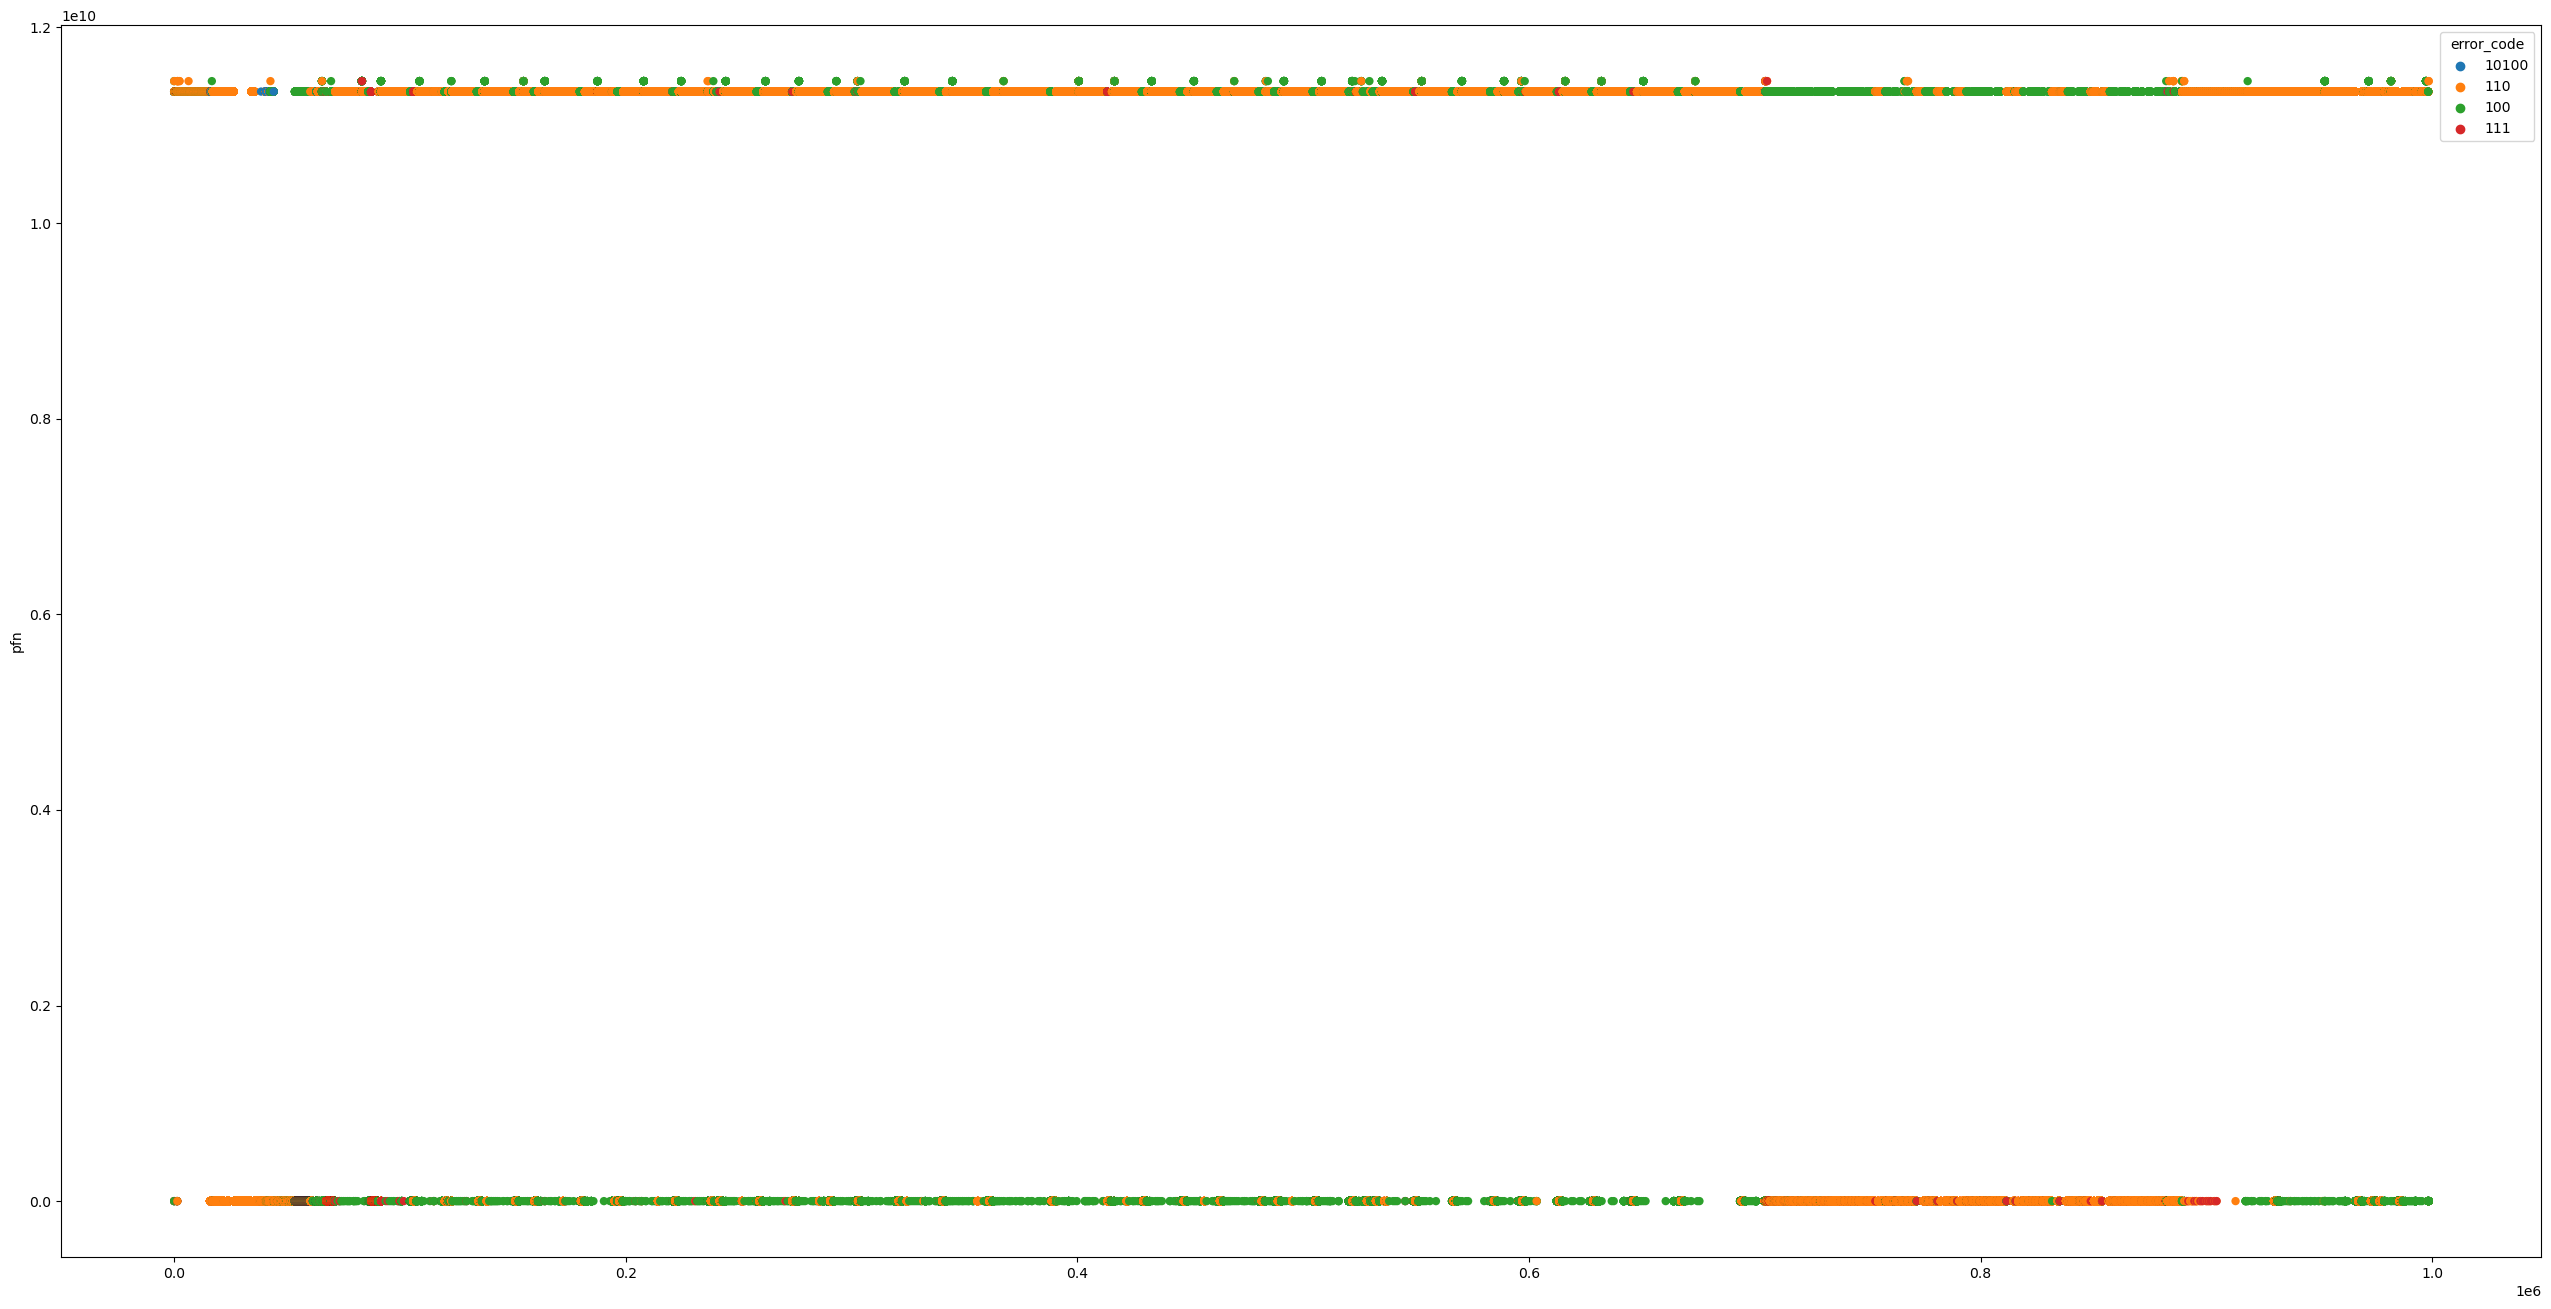

In [15]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(df)), y=df['pfn'], hue=df["error_code"], linewidth=0)

In [13]:
kernel_fault = df[df["pfn"] > 0.6e10]
user_fault = df[df["pfn"] <= 0.6e10]

<Axes: ylabel='pfn'>

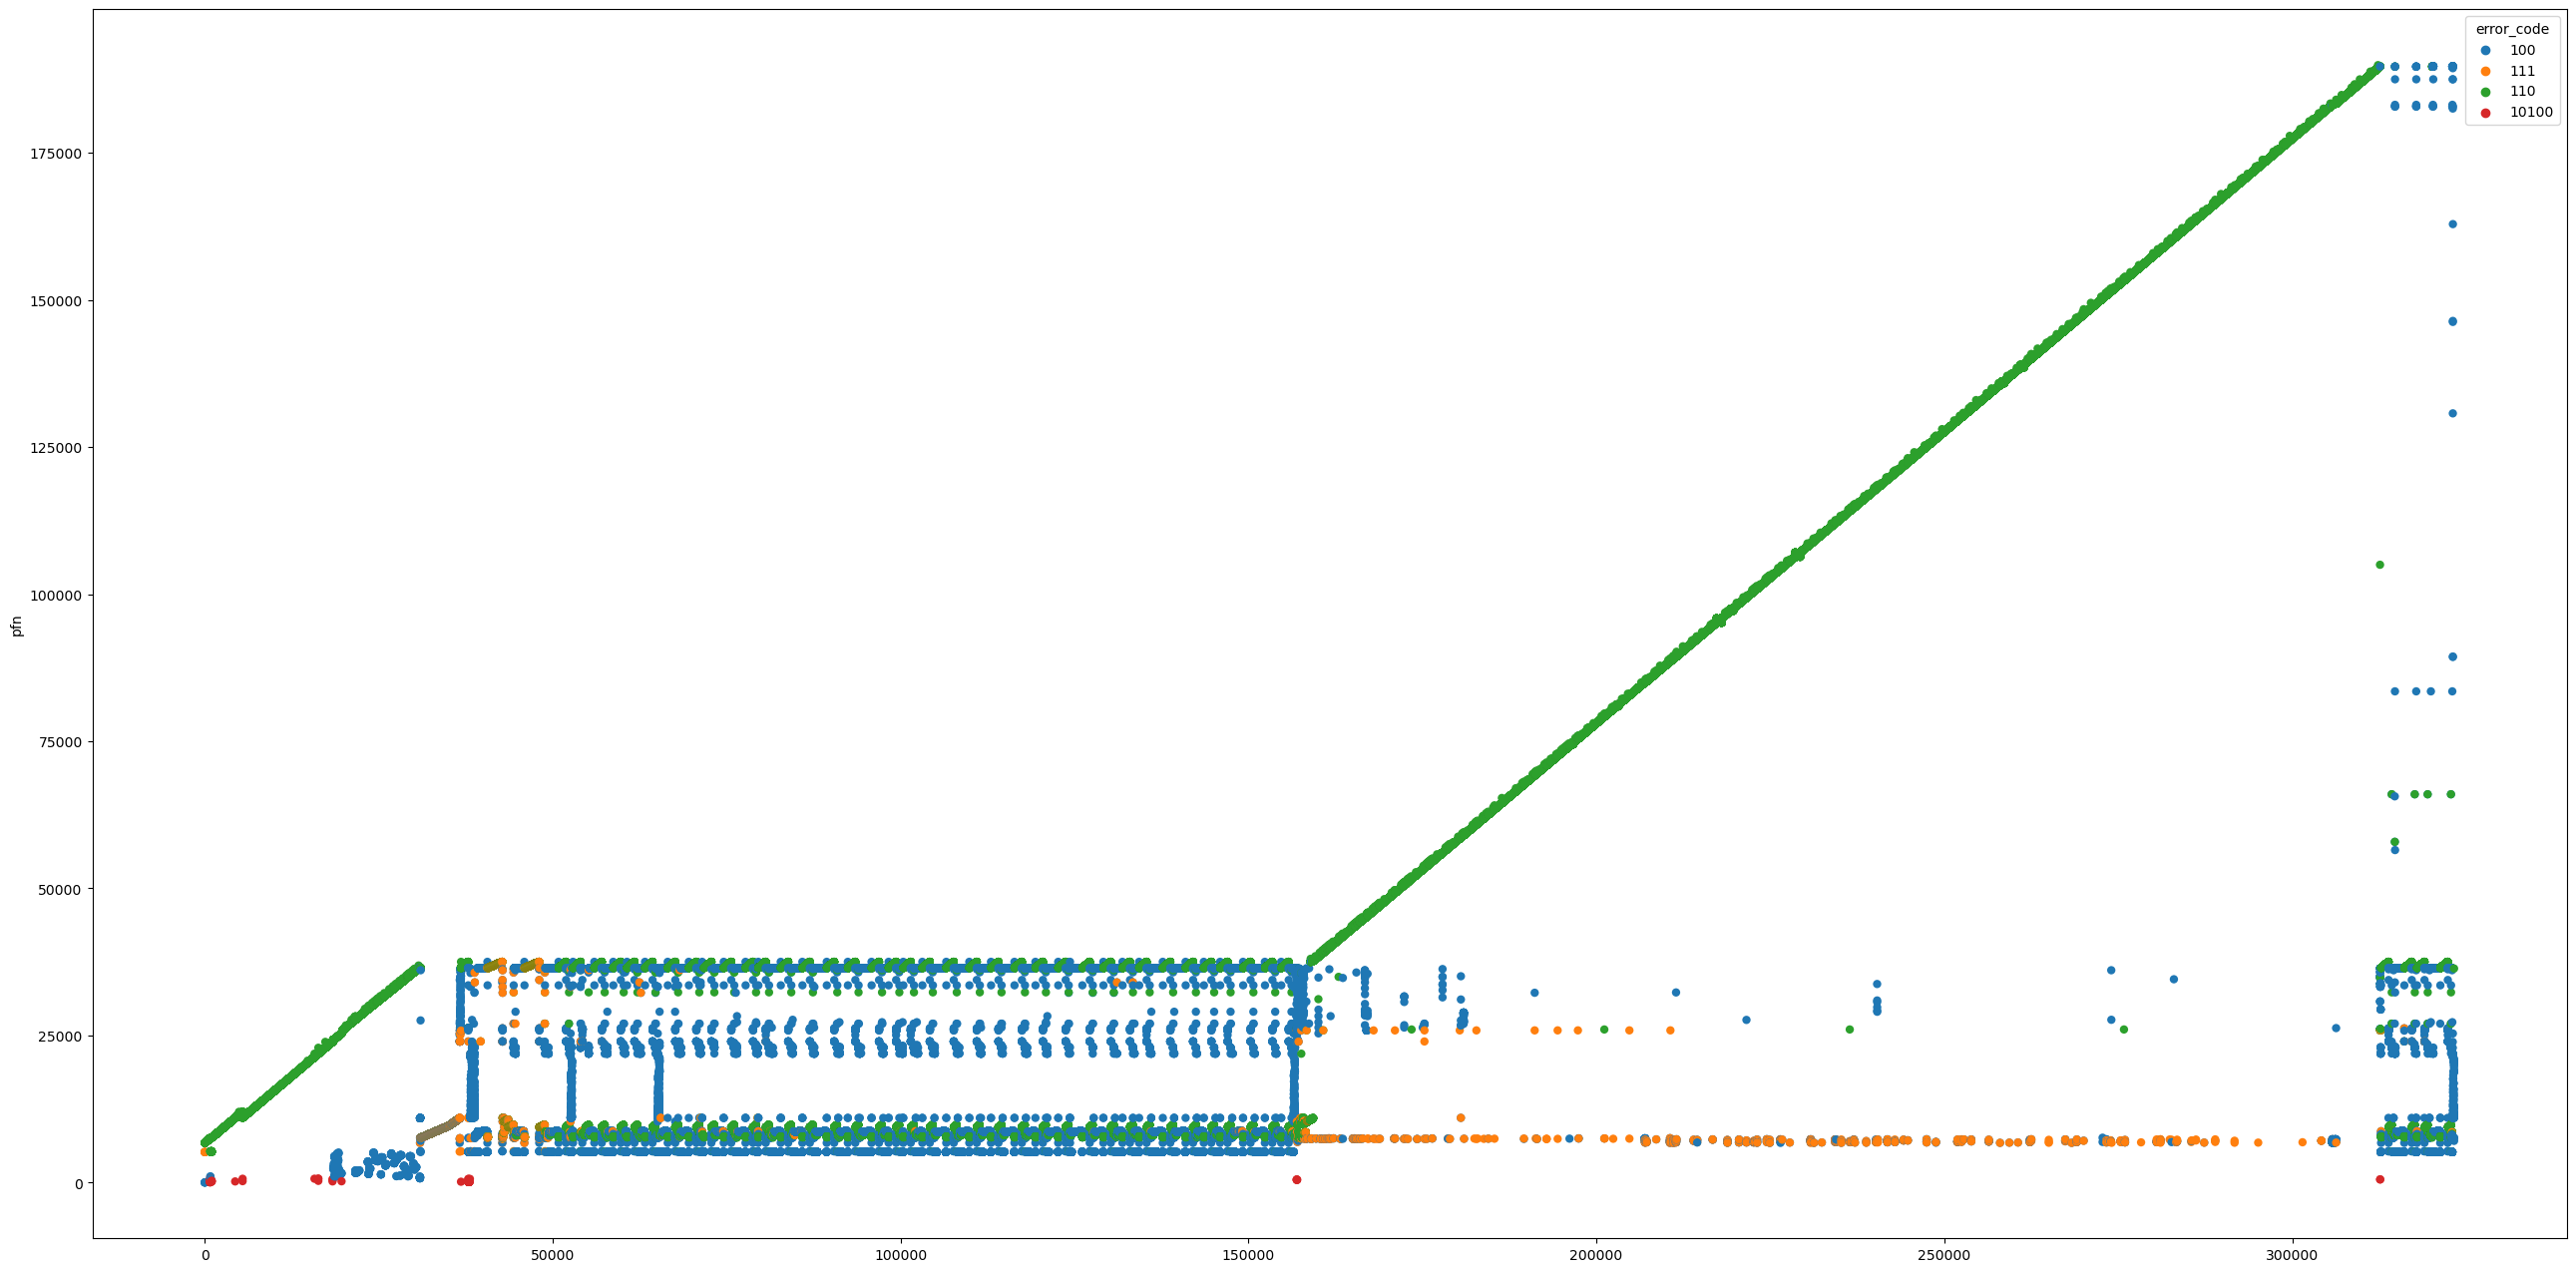

In [16]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(user_fault)), y=user_fault['pfn'], hue=user_fault["error_code"], linewidth=0)